# <div align="center">TP n° : Introduction to geomagnetism and models building</div>


## 1 Introduction


Earth's magnetic field, also known as the geomagnetic field, is the magnetic field that extends from Earth's interior out into space. It is the resultant of differents sources of magnetic field that result for instant from the iron motions in the Earth's core, the current passing through the mantle or the charged particules motions in the magnetosphere.

Earth's magnetic field sources can be divided in two categories : the interior and exterior sources. The interior sources are the iron motions in the Earth's core, the current passing through the mantle, the permanent magnetized materials in the crust, the charged particules motions in the oceans etc... 
The external sources are all the sources further away from the Earth's crust like the charged particles in the ionosphere and in the magnetosphere, the charged particles emanating from the Sun etc...

The magnetic field generated by electric currents due to the motion of convection currents of a mixture of molten iron and nickel in Earth's outer core is called the main field (these convection currents are caused by heat escaping from the core, a natural process called a geodynamo). The main field intensity vary between 30000nT and 60000nT wheareas the crust magnetic field's magnitude is 200nT.

Swarm is European Spatial Agency's first constellation mission for Earth's observation. It consists of three identical satellites called Alpha, Bravo and Charlie that orbits in low altitude at approximately 490 km altitude and deliver a detailed survey on the geomagnetic field. Its function is to provide data on the temporal evolution of the field and the electrical current in the atmosphere with magnetometers and other devices. Its objective is to study the core dynamic, mapping the litosphere's magnetisation, mapping in 3D the eletrical condictivity in the mantle, study the core-mantle interactions and so one. 
Swarm is a virtual observatory, a virtual observatory is a collection of data provided by differents sensors and researchers algorithms to study some phenomena. 
The geomagnetical virtual observatory product two different data, the "Observed Field" that estimate the magnetic field with all of its sources and the "Core Field" that adds differents filters to mask the contribution of charged particles in the atmosphere. 

## 2 Open the data from observatories 

The data we will use come from Swarm virtual observatory and ground observatories, these data are stored in *Computable Document Format* this format need to be openned with a python module called **cdflib**. We will use some of the function of this module to open the data file and create a dictionnary to find the data easily. The function we will use are : 
- **cdflib.CDF(path)** with which you can create a CDF class and that takes in argument the path of datas in your computer. 
- **cdf_file.cdf_info(name)** with which you get all the information from the CDF file.
- To create the dictionnary, you need to get the keys from the file with the function **info['zVariables']**. 
Finally, you can create the dictionnary : 

In [72]:
import cdflib 
import os

cdf_dir = 'donnees/cdf_files_basic_sync_functions_201'
data_file = os.path.join(cdf_dir, 'SW_OPER_VOBS_4M_2__20140301T000000_20210701T000000_0201_basic_sync_functions.cdf')
cdf_read = cdflib.CDF(data_file)
info = cdf_read.cdf_info()
zvars = info['zVariables']
alldata = {name: cdf_read.varget(name) for name in zvars}
print('>' ,alldata.keys())

> dict_keys(['Timestamp', 'Latitude', 'Longitude', 'Radius', 'B_OB', 'sigma_OB', 'B_CF', 'sigma_CF', 'Timestamp_SV', 'B_SV', 'sigma_SV'])


Now we can observe all the different keys of the dictonnary we used to store the data :
- **'Timestamp'** refers to the time data.
- (**'Radius', 'Latitude', 'Longitudes**) refers to the localisation of our observatories.
- **'B_OB'** and **'sigma_OB'** refers to the raw observations and incertitudes. 
- **'B_CF'** and **'sigma_CF'** refers to the observations cleaned from the anomalies detected in the raw observations.
- the term **'SV'** refers to the secular variations.

The next step is to plot these observations, we will use the module **matplotlib.pyplot** and a module called **cartopy** that can plot an Earth's map. 

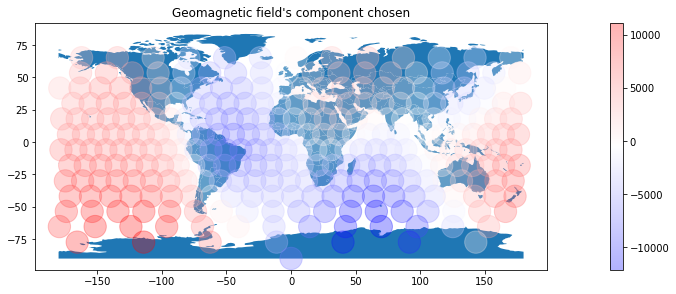

In [73]:
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd

def cdf_times_to_np_date(times):
    """
    Transform the times in cdf epoch into numpy dates, rounding month to nearest.
    """
    dates = []
    for t in times:
        if t != t:
            # if time is a nan, date should be a nan as well
            dates.append(np.float('nan'))
            continue
        year, month, day = cdflib.cdfepoch.breakdown_epoch(t)[:3]
        if day > 15:
            if month == 12:
                year += 1
                month = 1
            else:
                month += 1
        dates.append(np.datetime64('{}-{:02}'.format(year, month)))
    return dates

def compute_unique_times_list(times_list):
    list_t = []
    for t in times_list:
        if t not in list_t:
            list_t.append(t)
    return list_t

def compute_MF_list(Magnetic_field, choice):
    B_choice = []
    for k in range(len(Magnetic_field)):
        B_choice.append(Magnetic_field[k][choice])
    return B_choice
    

## Choice of the date and component
unique_times_list = cdf_times_to_np_date(compute_unique_times_list(alldata['Timestamp']))
date = '2017-05' # Arbitrary choice of the date to plot 
index_temps = np.argwhere((cdf_times_to_np_date(alldata['Timestamp'])) == np.datetime64(date))[0][0]
N_VO = 300
choice = 2

## Creation of the different lists
latitudes = alldata['Latitude'][index_temps:index_temps+N_VO]
longitudes = alldata['Longitude'][index_temps:index_temps+N_VO]
MF = compute_MF_list(alldata['B_CF'][index_temps:index_temps+N_VO], choice)

## Lines plotting the geomagnetic field 
fig = plt.figure(figsize=(50,10))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax1=fig.add_subplot(221)
world.plot(ax=ax1)
map_cf = ax1.scatter(longitudes, latitudes, c=MF, s=500, alpha=0.3,cmap='bwr')
ax1.set_title("Geomagnetic field's component chosen")
plt.colorbar(map_cf, ax=ax1)
plt.show()

## 3 Physical description of the problem 

### 3.1 Description of the problem

In areas between $R_{Earth}$ and $R_{ionosphere}$ where there are not electric current, the magnetic potential is solution of the Laplace's equation :$\nabla^2 V=0$. 

In spherical coordinates, the Laplacian operator can be written as follows : $\nabla^2 = \frac{2}{r}\frac{\delta}{\delta r}+\frac{\delta^2}{\delta r^2}+\frac{1}{r^2sin(\Theta)}\frac{\delta}{\delta \Theta}(sin(\theta \frac{\delta}{\delta \Theta}))+ \frac{1}{r^2sin^2(\Theta)}\frac{\delta^2}{\delta \Phi^2}$.

We can solve this equation using spherical harmonics, we will get the following formula for the magnetic field created by the internal sources : 

<div align="center"> <mark>$B_i(r, \Theta, \Phi) = \Sigma^\infty_{n=1} (\frac{a}{r})^{n+2} \Sigma^{n}_{m=0} (g_{n}^m \Pi^{mc}_{ni}(\Theta, \Phi) + h_n^m \Pi^{ms}_{ni}(\Theta, \Phi))$.</mark> </div>

*a is the reference radius chosen as $a=R_{earth}$, the $P_n^m$ are the Legendre associated polynomials functions that will be determined by one of the python code. $g^m_n,h^m_n,q_n^m,s_n^m$ are the the Gauss coefficient that will appear as the variables of our system when we will use the estimation by least square.$\Theta$ is the co-latitude and $\Phi$ is the longitude and, r is the geocentric distance.*

Solving this equation will be equivalent to solve the equation <mark>$Y = HX$</mark> *with **Y** the magnetic field's values, **H** a matrix depending on the positions and **X** the gauss's coefficients vector*.

To compute the **H** matrix, we will use the formulas of the vectors $\Pi^{mc}_{ni}$ and $\Pi^{ms}_{ni}$ that have the following forms : 

<div align="center"> <mark> $ \Pi^{mc}_{ni}(\Theta, \Phi) = (n+1)P^m_n(cos(\Theta))cos(m\Phi)\textbf{$e_r$} - \frac{d P^m_n(cos(\Theta))}{d\Theta}cos(m\Phi) \textbf{$e_{\Theta}$}+\frac{m}{sin(\Theta)}P^m_n(cos(\Theta))sin(m\Phi)\textbf{$e_{\Phi}$} $ </mark> </div>

<div align="center"> <mark> $ \Pi^{ms}_{ni}(\Theta, \Phi) = (n+1)P^m_n(cos(\Theta))sin(m\Phi)\textbf{$e_r$} - \frac{d P^m_n(cos(\Theta))}{d\Theta}sin(m\Phi) \textbf{$e_{\Theta}$}+\frac{m}{sin(\Theta)}P^m_n(cos(\Theta))cos(m\Phi)\textbf{$e_{\Phi}$} $ </mark> </div>


### 3.2 Solving the direct problem :

Now, you will try to compute the geomagnetic field using given gauss coefficients. We will use a model previously created that is called **CHAOS-7**. This model is determined using observations done by satellites *Swarm, CryoSat-2, Champ, SAC-C and  Ørsted* and with ground observatories. This model consist of time dependant internal field without degrees up to 20, the parameters were determinated using iteratively reweighted regularized least-squares procedure and using the previous CHAOS models. This model is used to investigate changes in the geomagnetic field. 

To compute the direct problem, we need to solve the equation $Y = HX$ using the CHAOS-7's gauss coefficient vector X. We will only work for now with the internal field's gauss coefficients. The H matrix is computed using the previous equations of $ \Pi^{mc}_{ni} $ and $ \Pi^{ms}_{ni}(\Theta, \Phi) $. 

To plot the geomagnetic field we will also use a python module called *geopandas* that can allow us to plot the Earth's map.

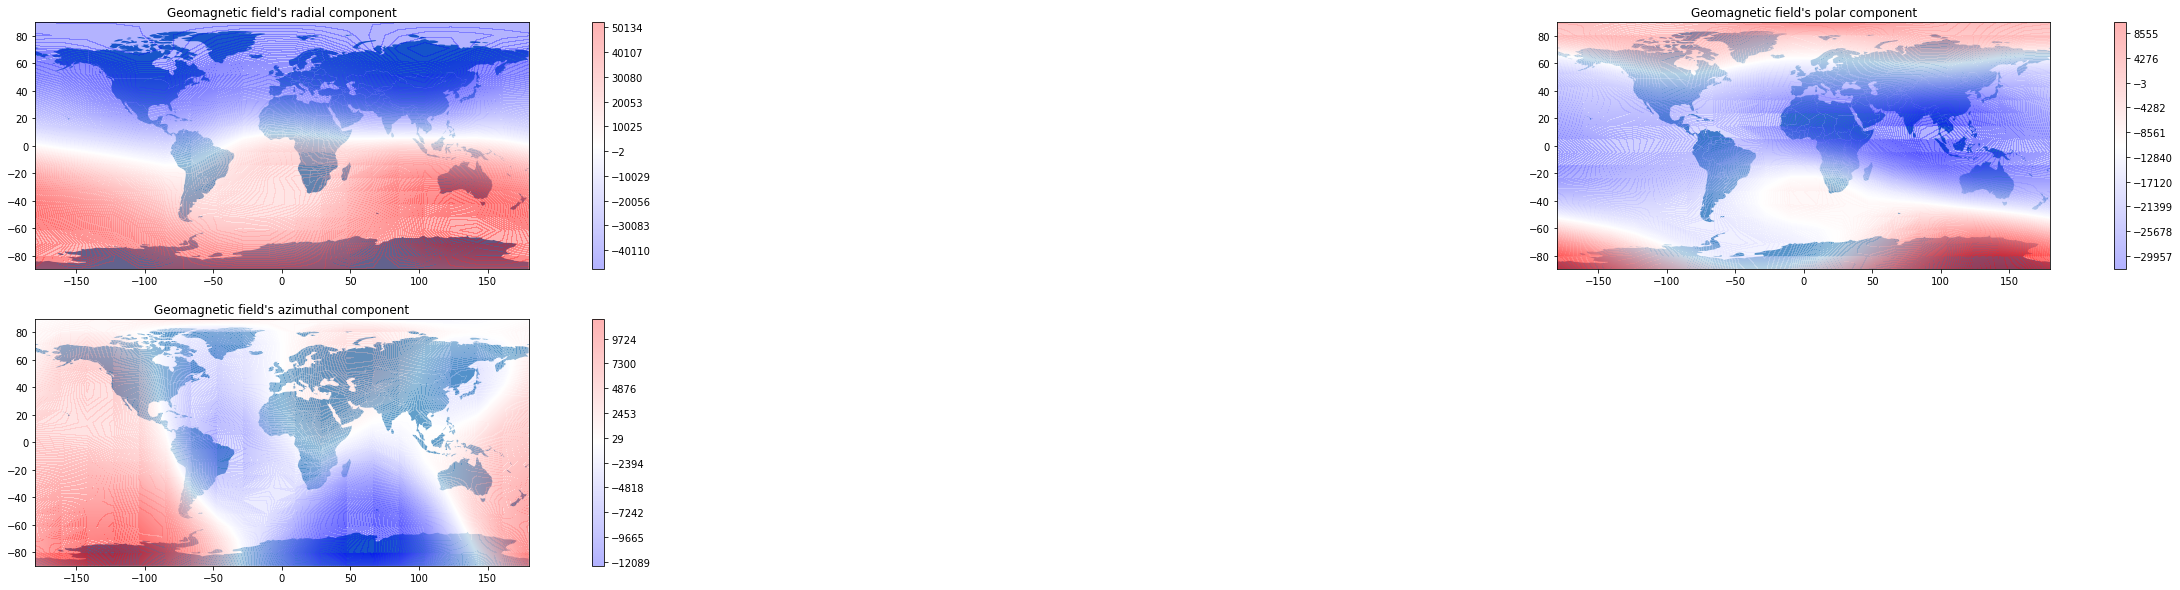

In [74]:
from functools import lru_cache
from scipy.special import lpmv
import math
import h5py

%run functions.py

with h5py.File('donnees/CHAOS-7.hdf5') as file:
    #  print(file.keys())
    gauss_coeffs = np.array(file['gnm'])
    times_chaos = np.array(file['times'])

radius = 6861
eps = 10e-7
N = 20
L_max = 20
latitudes = np.linspace(0, 180, N)
longitudes = np.linspace(-180, 180, N)
th = 90 - latitudes + eps
ph = longitudes
date = 2018.
positions = compute_grid_positions(radius, th, ph, N)
index_temps = np.argwhere(times_chaos == date)
B = np.zeros(3*N*N)
for k in range(0, len(positions), 3):
    B[k], B[k+1], B[k+2] = compute_MF_at_loc(radius, np.deg2rad(90)-positions[k+1], positions[k+2], gauss_coeffs, index_temps)
    
fig = plt.figure(figsize=(50,10))
ph, th = np.meshgrid(ph, th)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)
create_graph(fig, 221, world, th, ph, BR_meshgrid, "Geomagnetic field's radial component")
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "Geomagnetic field's polar component")
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "Geomagnetic field's azimuthal component")
plt.show()

### 3.3 Solving the inverse problem :

The next part of the practicium is to compute the inverse problem, using the least-square method and a model called the prior. We will create our own model using the geomagnetic field's observations. We need to maximize the probability of two gauss multivariable distributions : the product of the observations distributions and the prior normal distribution. 

After doing the demonstration, that is available on the written report, we can state that the gauss coefficient's vector **X** will have the following form : 
<div align="center"> <mark> $X = (\Sigma_P^{-1} + H^T \Sigma_{Obs}^{-1} H ) ^{-1} ( \Sigma_P^{-1} \mu_p +  H^T \Sigma_{Obs}^{-1} Y)$ </mark> </div>

with $\Sigma_P$ the covariance matrix of the prior model, $\mu_p$ its mean vector and $\Sigma_{Obs}$ the covariance matrix of the observations.

The prior's covariance matrix is given, the observations covariance matrix is computed with the data given by satellites. 

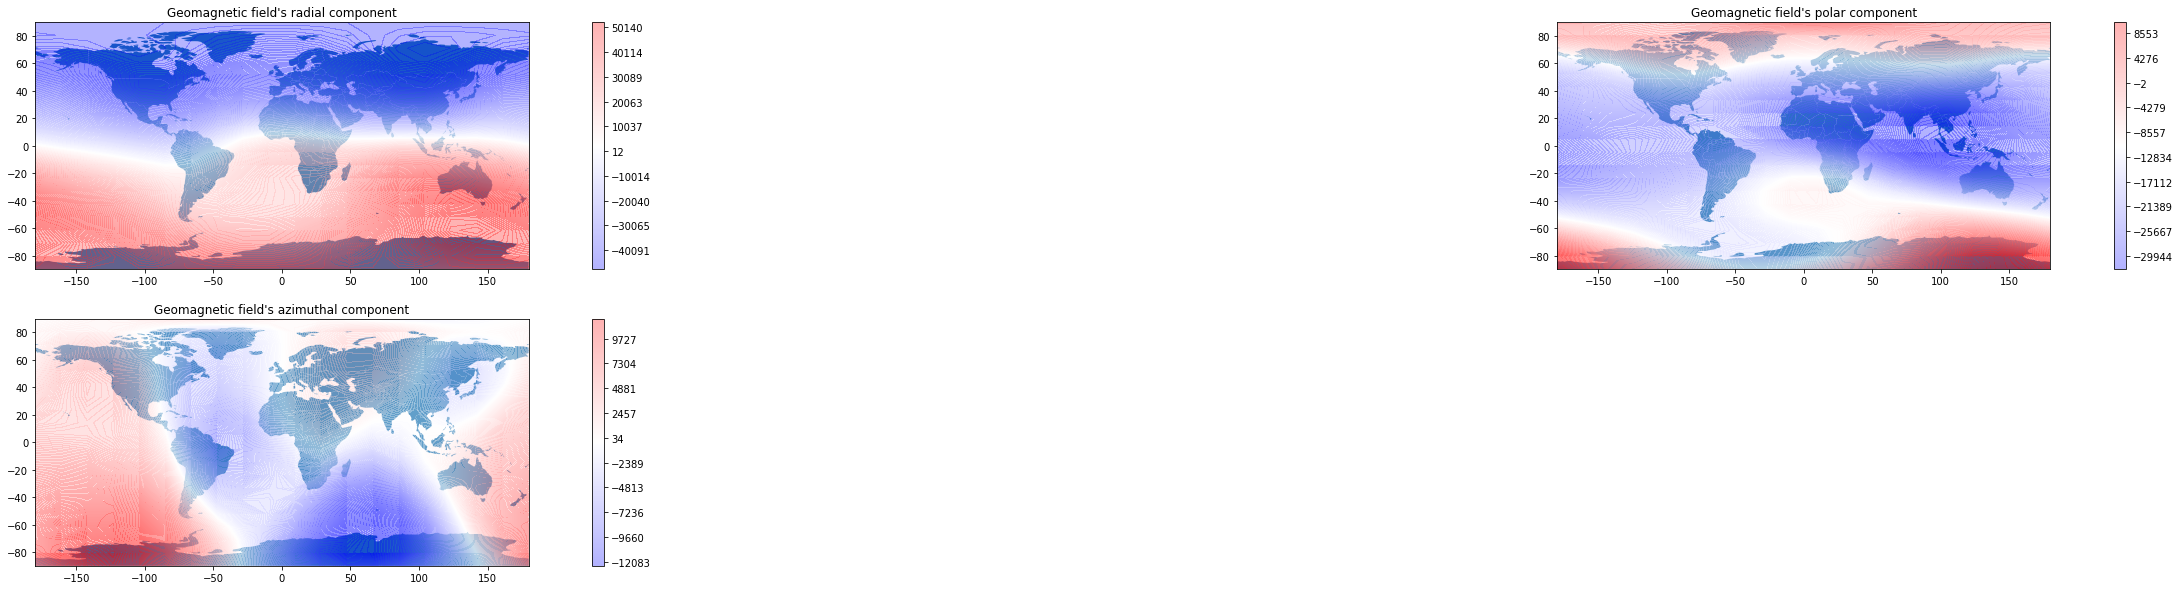

In [75]:
%run functions.py


#  dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']

#  Directories
N_VO = 300
L_max = 13
date = '2017-05'
cm_prior = np.loadtxt('prior_cov_matrix.txt')
cdf_dir = 'donnees/cdf_files_basic_sync_functions_201'
swarm_file = os.path.join(cdf_dir, 'SW_OPER_VOBS_4M_2__20140301T000000_20210701T000000_0201_basic_sync_functions.cdf')
cdf_read = cdflib.CDF(swarm_file)
info = cdf_read.cdf_info()
zvars = info['zVariables']
alldata = {name: cdf_read.varget(name) for name in zvars}
times = cdf_times_to_np_date(alldata['Timestamp'])
index_temps = np.argwhere(times == np.datetime64(date))
unique_times = compute_unique_times_list(times)
X_CF = compute_gauss_coefs_vector(swarm_file, '2017-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)


## Plotting the geomagnetic field from our own model
# Plotting parameters
radius = 6861
eps = 10e-7
N = 20
th = np.linspace(-90+eps, 90+eps, N)
ph = np.linspace(-180, 180, N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
L_max = 13
B = compute_B(positions, N, L_max, X_CF)

#  Lines plotting it
fig = plt.figure(figsize=(50,10))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ph, th = np.meshgrid(ph, th)
levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "Geomagnetic field's radial component")
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "Geomagnetic field's polar component")
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "Geomagnetic field's azimuthal component")
plt.show()


### 3.4 Plotting the difference between the observed field and the core field 

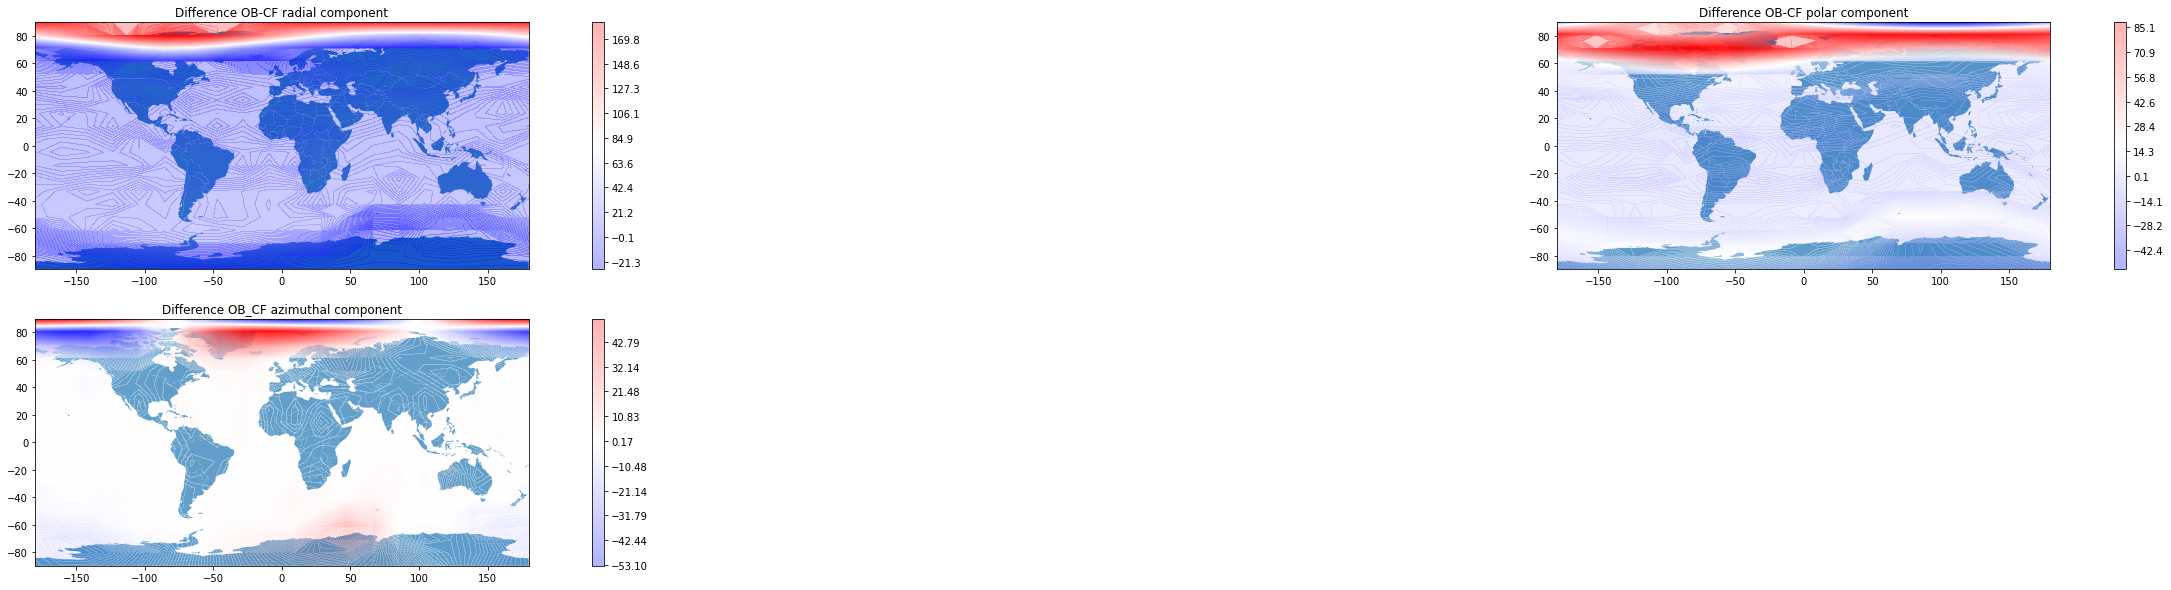

In [76]:
# Plotting parameters
radius = 6861
eps = 10e-7
N = 20
th = np.linspace(-90+eps, 90+eps, N)
ph = np.linspace(-180, 180, N)
positions = compute_grid_positions(radius, th, ph, N)

X_CF = compute_gauss_coefs_vector(swarm_file, '2017-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)
X_OB = compute_gauss_coefs_vector(swarm_file, '2017-05', 13, 300, 'B_OB', 'sigma_OB', cm_prior)
# Compute B
L_max = 13
B_CF = compute_B(positions, N, L_max, X_CF)
B_OB = compute_B(positions, N, L_max, X_OB)
B_difference = B_OB - B_CF

#  Lines plotting it
fig = plt.figure(figsize=(50,10))
ph, th = np.meshgrid(ph, th)
levels_B = lambda B: np.linspace(np.min(B_difference), np.max(B_difference), N)
BR_meshgrid = compute_B_meshgrid(B_difference, 0, N)
Bth_meshgrid = compute_B_meshgrid(B_difference, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B_difference, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "Difference OB-CF radial component")
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "Difference OB-CF polar component")
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "Difference OB_CF azimuthal component")
plt.show()

### 3.5 Plotting the secular variations 

> unique_times_list_SV : [numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01')]


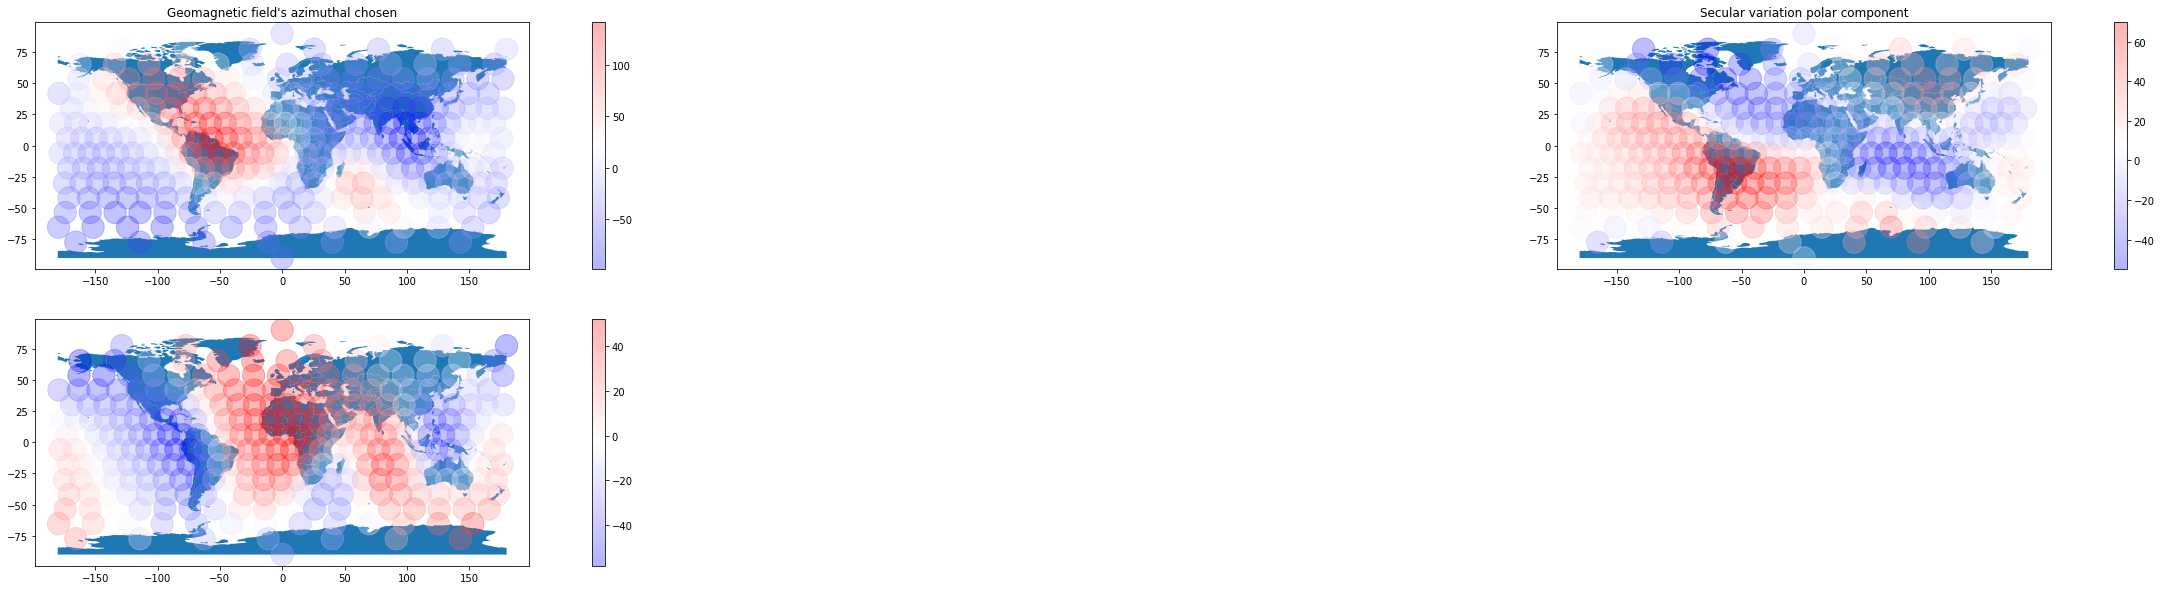

In [77]:
# Choice of the date and component
times_list_SV = alldata['Timestamp_SV']
for k in range(len(times_list_SV)-1 , -1, -1):
    if np.isnan(times_list_SV[k]):
        times_list_SV = np.delete(times_list_SV, k)
unique_times_list_SV = compute_unique_times_list(cdf_times_to_np_date(times_list_SV))
print('> unique_times_list_SV :', unique_times_list_SV)


## Choice of the date and component
date = '2014-09' # Arbitrary choice of the date to plot 
index_temps = np.argwhere((cdf_times_to_np_date(alldata['Timestamp_SV'])) == np.datetime64(date))[0][0]
N_VO = 300

## Creation of the different lists
latitudes = alldata['Latitude'][index_temps:index_temps+N_VO]
longitudes = alldata['Longitude'][index_temps:index_temps+N_VO]
B_SVR = compute_MF_list(alldata['B_SV'][index_temps:index_temps+N_VO], 0)
B_SVth = compute_MF_list(alldata['B_SV'][index_temps:index_temps+N_VO], 1)
B_SVph= compute_MF_list(alldata['B_SV'][index_temps:index_temps+N_VO], 2)

## Lines plotting the geomagnetic field 
fig = plt.figure(figsize=(50,10))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

ax1=fig.add_subplot(221)
world.plot(ax=ax1)
map_cf = ax1.scatter(longitudes, latitudes, c=B_SVR, s=500, alpha=0.3,cmap='bwr')
ax1.set_title("Secular variation radius component")
plt.colorbar(map_cf, ax=ax1)

ax2=fig.add_subplot(222)
world.plot(ax=ax2)
map_cf = ax2.scatter(longitudes, latitudes, c=B_SVth, s=500, alpha=0.3,cmap='bwr')
ax2.set_title("Secular variation polar component")
plt.colorbar(map_cf, ax=ax2)

ax3=fig.add_subplot(223)
world.plot(ax=ax3)
map_cf = ax3.scatter(longitudes, latitudes, c=B_SVph, s=500, alpha=0.3,cmap='bwr')
ax1.set_title("Geomagnetic field's azimuthal chosen")
plt.colorbar(map_cf, ax=ax3)
             
plt.show()

### 3.6 Stuying the variations of gauss coefficients over time

We will study the variations of gauss coefficients over time, to do so we will use the observed field and the core field data.

In [78]:
%run functions.py

X_matrix_OB = compute_gauss_coefs_matrix(swarm_file, 13, 300, 'B_OB', 'sigma_OB', cm_prior, unique_times)
print(np.shape(X_matrix_OB))
X_matrix_CF = compute_gauss_coefs_matrix(swarm_file, 13, 300, 'B_CF', 'sigma_CF', cm_prior, unique_times)
print(np.shape(X_matrix_CF))

(195, 22)
(195, 22)


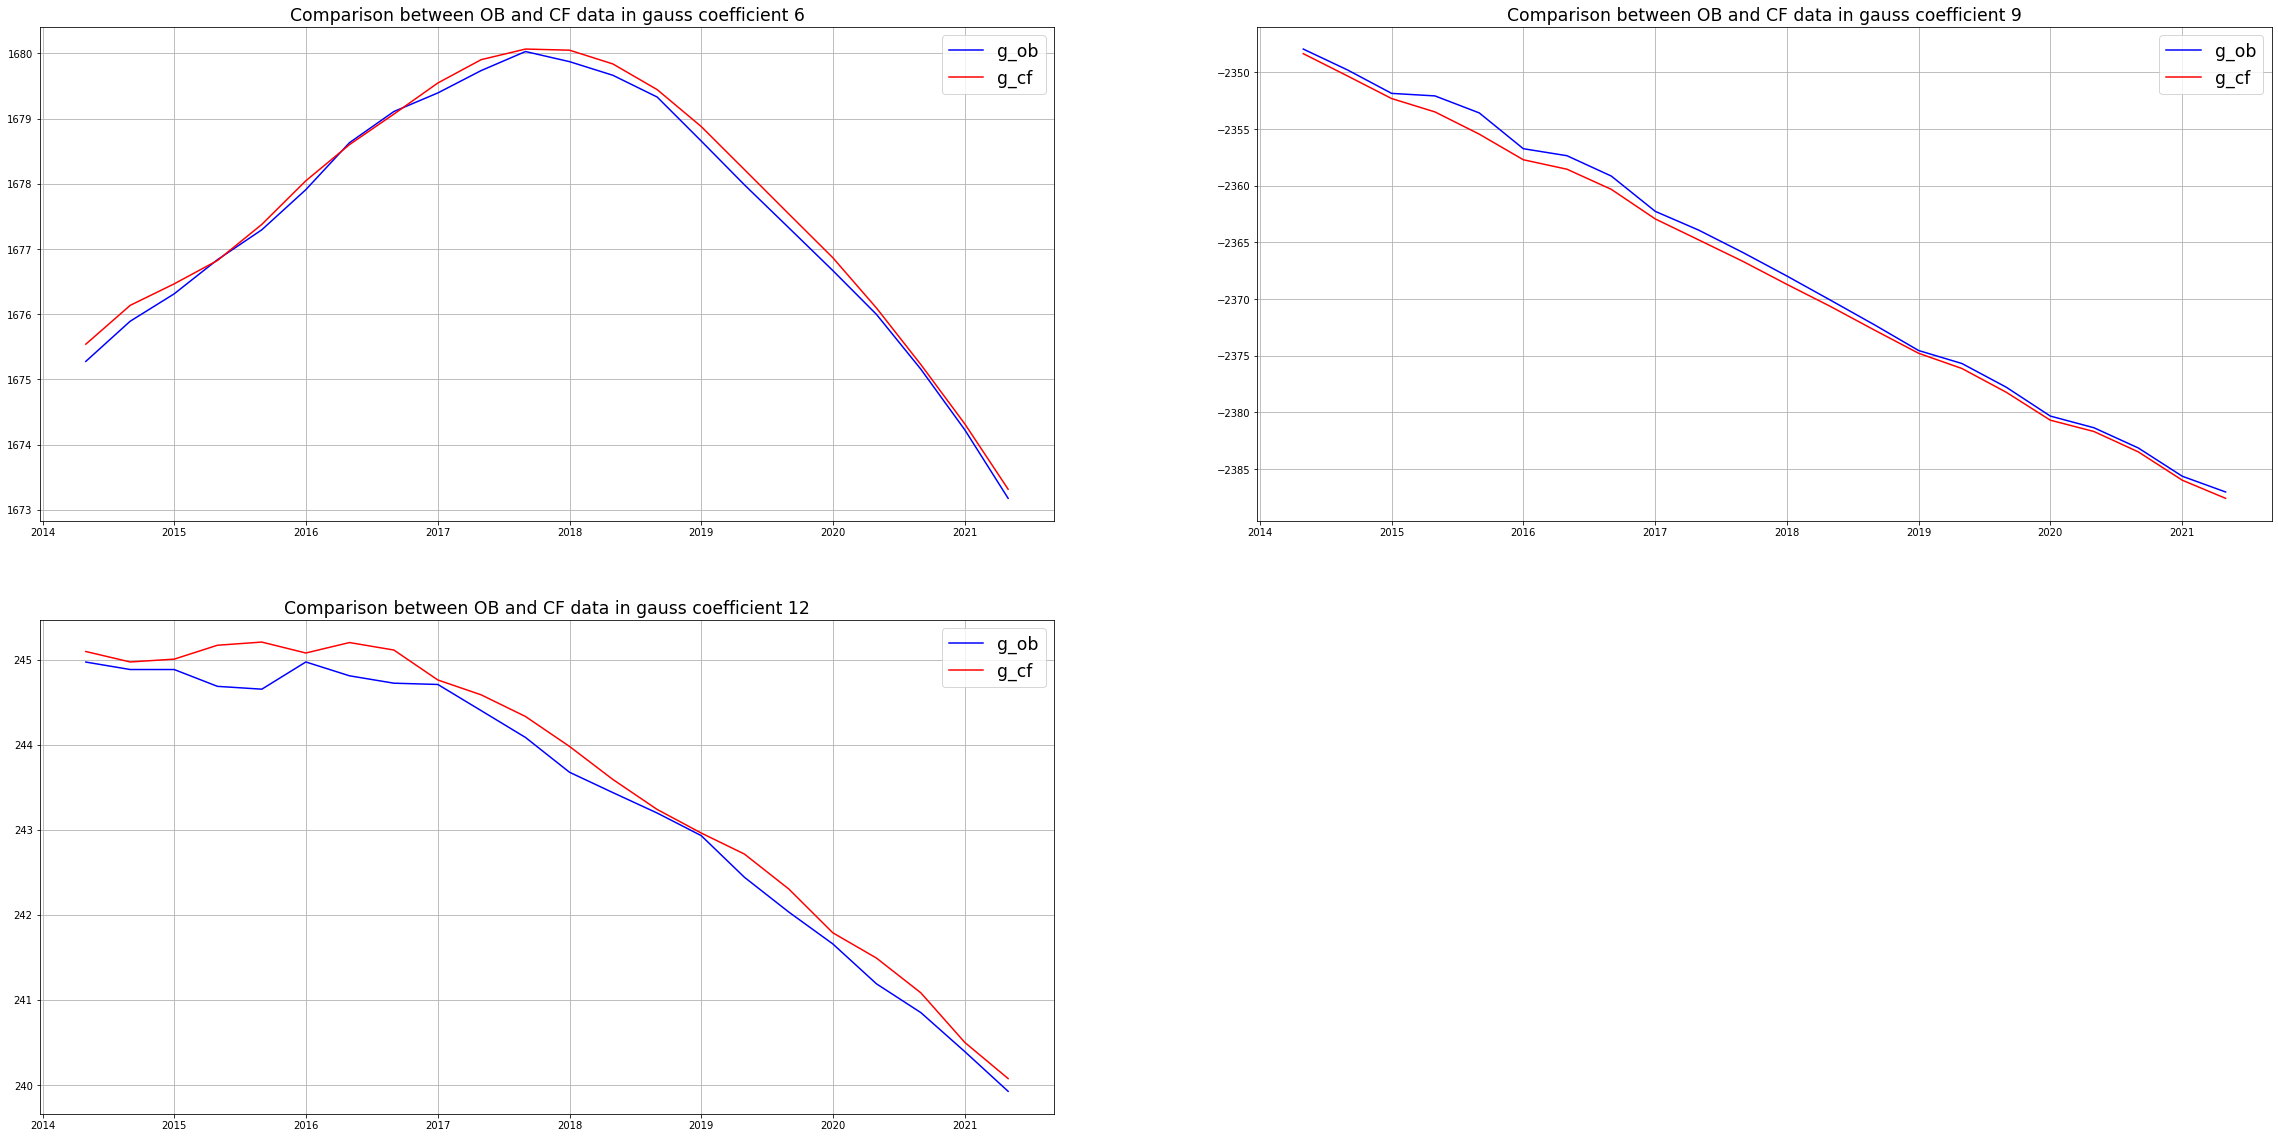

In [79]:
%run functions.py
fig = plt.figure(figsize=(40,20))
create_graph_compare_gauss_coefs(6, 221, unique_times, X_matrix_OB, X_matrix_CF)
create_graph_compare_gauss_coefs(9, 222, unique_times, X_matrix_OB, X_matrix_CF)
create_graph_compare_gauss_coefs(12, 223, unique_times, X_matrix_OB, X_matrix_CF)
plt.show()

### 3.7 Adding an histogram of the different geomagnetic field values

300


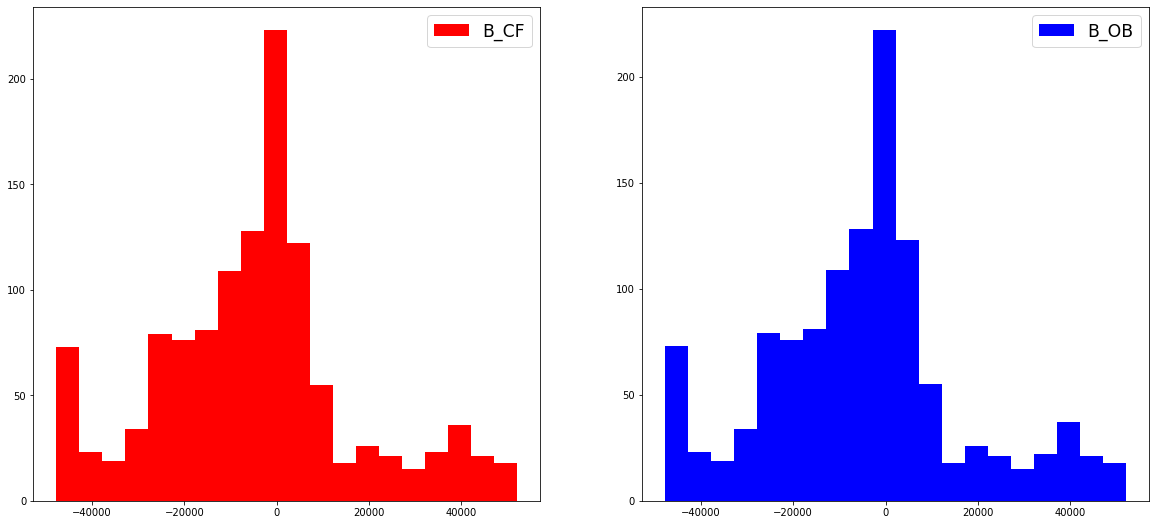

In [80]:
d = '2017-05'
index_temps = np.argwhere((cdf_times_to_np_date(alldata['Timestamp'])) == np.datetime64(date))[0][0]
B_CF_choice = compute_MF_list(alldata['B_CF'][index_temps:index_temps+N_VO], choice)
B_OB_choice = compute_MF_list(alldata['B_OB'][index_temps:index_temps+N_VO], choice)


fig = plt.figure(figsize=(20,20))
plt.title('Comparison between histograms of B_OB and B_CF at date chosen')
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax1.hist(B_CF, bins = 20, color='r',  label='B_CF')
ax2.hist(B_OB, bins = 20, color='b', label='B_OB')
ax1.legend(fontsize='xx-large')
ax2.legend(fontsize='xx-large')
plt.show()